In [34]:
import pandas as pd 


In [35]:
import tensorflow

import yfinance as yf
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [36]:
df = yf.download(tickers='DOGE-USD')
target_col = 'close'
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550
2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520
2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080
2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960
2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270
...,...,...,...,...,...,...
2022-02-17,0.149050,0.149889,0.138071,0.138552,0.138552,721382126
2022-02-18,0.138594,0.142097,0.136960,0.138768,0.138768,563817289
2022-02-19,0.138764,0.145906,0.138751,0.141206,0.141206,655782652


In [37]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [38]:
train, test = train_test_split(df, test_size=0.2)


In [39]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

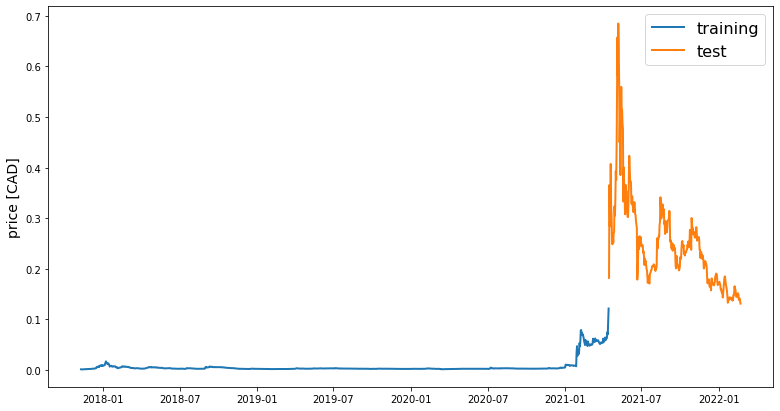

In [40]:
line_plot(train['Close'], test['Close'], 'training', 'test', title='')


In [41]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

In [42]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)


In [43]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)


In [44]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test


In [45]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [46]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'


In [47]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    df, 'Close', window_len=window_len, zero_base=zero_base, test_size=test_size)


In [48]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)


Epoch 1/20
39/39 [==============================] - 0s 11ms/step - loss: 0.0664
Epoch 2/20
39/39 [==============================] - 0s 5ms/step - loss: 0.0366
Epoch 3/20
39/39 [==============================] - 0s 5ms/step - loss: 0.0304
Epoch 4/20
39/39 [==============================] - 0s 5ms/step - loss: 0.0282
Epoch 5/20
39/39 [==============================] - 0s 6ms/step - loss: 0.0255
Epoch 6/20
39/39 [==============================] - 0s 8ms/step - loss: 0.0237
Epoch 7/20
39/39 [==============================] - 0s 9ms/step - loss: 0.0229
Epoch 8/20
39/39 [==============================] - 0s 9ms/step - loss: 0.0213
Epoch 9/20
39/39 [==============================] - 0s 10ms/step - loss: 0.0226
Epoch 10/20
39/39 [==============================] - 0s 8ms/step - loss: 0.0209
Epoch 11/20
39/39 [==============================] - 0s 6ms/step - loss: 0.0173
Epoch 12/20
39/39 [==============================] - 0s 6ms/step - loss: 0.0192
Epoch 13/20
39/39 [============================

In [49]:
targets = test['Close'][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.05212045696331409

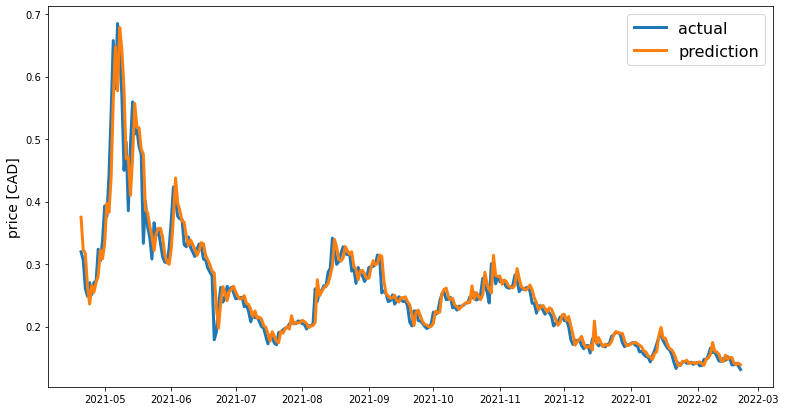

In [50]:
preds = test['Close'].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)